In [2]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("talk")
#rc('axes', labelsize=20, titlesize=20)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss

from ABC_algorithm import ABC 

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Normal example

In [51]:
######
# set up for the normal ABC example
######

prior_mean = -4.0
prior_sd = 3
likelihood_sd = 1

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=5)

post_sd = np.power((1.0/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2)),-1/2)
post_mean = (prior_mean/np.power(prior_sd,2) + np.sum(data)/(np.power(likelihood_sd,2)))/(1/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2))
print post_mean, "is posterior mean"
print post_sd, "is posterior std dev"

0.514825002173 is posterior mean
0.195652173913 is posterior std dev


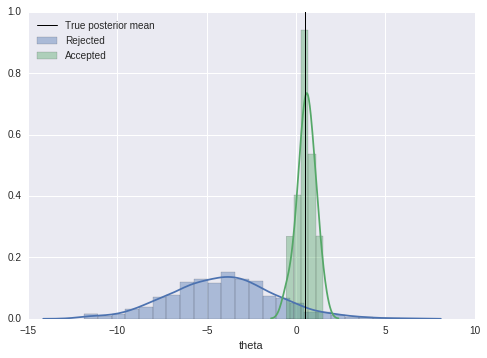

In [52]:
######
# run ABC for the normal example
######

df = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, 0.2, data , 1000)

######
# plot the accepted and rejected params
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    sns.distplot(sub_df.theta, ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.savefig('plots/1d_normal_abc.pdf')

## Evaluate MSE

In [49]:
epsilon_count = 10
epsilon = 0
epsilon_increment = 0.1

k = 1000
n = 100

error_epsilon_list = []

for _ in range(epsilon_count):
    epsilon = epsilon + epsilon_increment
    #print "epsilon:{}".format(epsilon)

    abc_post_medians = []
    dist_from_truth = []

    for i in range(k):
        #print "Iteration:{}".format(i)
        df_ei = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, epsilon, data, n)
        abc_post_mean = df_ei[df_ei.accept == 1].theta.mean()
        dist_from_truth.append(abs(abc_post_mean - post_mean))
    
    squared_dist_from_truth = np.power(dist_from_truth,2)
    mse = np.mean(squared_dist_from_truth)
    mse_err = 1.96*np.std(squared_dist_from_truth)
    
    mc_bias = np.mean(dist_from_truth)
    mc_bias_err = 1.96*np.std(dist_from_truth)
    
    var = np.var(dist_from_truth)
    
    mse_check = np.add(var, np.power(mc_bias,2))
    
    error_epsilon_list.append({'epsilon':epsilon ,
                               'bias':mc_bias, 'bias_err':mc_bias_err, 
                               'mse':mse, 'mse_err':mse_err,
                               'var':var,
                               'mse_check':mse_check
                              })
    
mse_df = pd.DataFrame(error_epsilon_list)
#mse_df.bias = mse_df.mse - mse_df.variance


#plt.scatter(mse_df['epsilon'], mse_df['bias'])
#pylab.errorbar(mse_df['epsilon'], mse_df['bias'],yerr=mse_df['bias_err'],linestyle='None') 
#plt.show()
#plt.scatter(mse_df['epsilon'], mse_df['mse'])
#pylab.errorbar(mse_df['epsilon'], mse_df['mse'],yerr=mse_df['mse_err'],linestyle='None')
#plt.show()
#sns.regplot(x=mse_df.epsilon, y=mse_df.variance, marker="+", fit_reg=False, label='Variance')
#sns.regplot(x=mse_df.epsilon, y=mse_df.bias, marker="+", fit_reg=False, label='Bias')
#plt.legend(loc='upper left')



In [39]:
print mse_df

       bias  bias_err  epsilon       mse  mse_check   mse_err       var
0       NaN       NaN      0.1       NaN        NaN       NaN       NaN
1       NaN       NaN      0.2       NaN        NaN       NaN       NaN
2       NaN       NaN      0.3       NaN        NaN       NaN       NaN
3  0.212259  0.326800      0.4  0.072854   0.072854  0.186994  0.027801
4  0.190920  0.237937      0.5  0.051187   0.051187  0.110169  0.014737
5  0.186297  0.257019      0.6  0.051902   0.051902  0.139814  0.017196
6  0.170565  0.252610      0.7  0.045703   0.045703  0.118971  0.016611
7  0.161195  0.218646      0.8  0.038428   0.038428  0.090509  0.012444
8  0.145969  0.233736      0.9  0.035528   0.035528  0.103615  0.014221
9  0.164626  0.235226      1.0  0.041505   0.041505  0.106147  0.014403


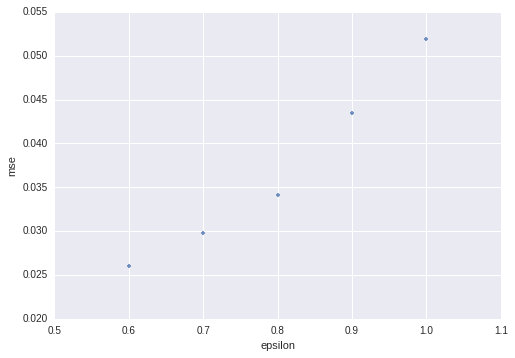

In [50]:
sns.regplot(x=mse_df.epsilon, y=mse_df.mse, marker="+", fit_reg=False, label='MSE')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.mse, yerr=mse_df.mse_err, linestyle="None")

plt.savefig('plots/1d_normal_mse_epsilon_k{}_n{}_.pdf'.format(k,n))


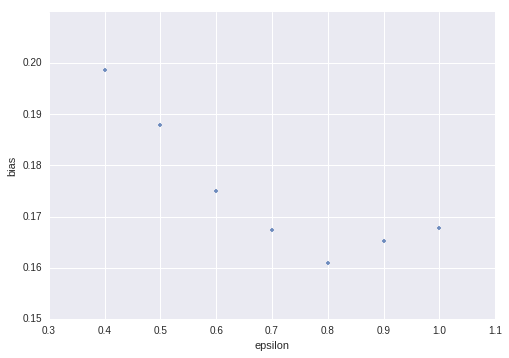

In [45]:
sns.regplot(x=mse_df.epsilon, y=mse_df.bias, marker="+", fit_reg=False, label='bias')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.bias, yerr=mse_df.bias_err, linestyle="None")
plt.savefig('plots/1d_normal_bias_epsilon_k{}_n{}_.pdf'.format(k,n))

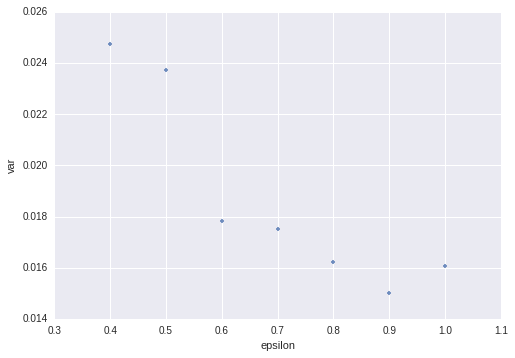

In [46]:
sns.regplot(x=mse_df.epsilon, y=mse_df['var'], marker="+", fit_reg=False, label='MSE')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.bias, yerr=mse_df.bias_err, linestyle="None")
#plt.savefig('plots/1d_normal_var_epsilon_k{}_n{}_.pdf'.format(k,n))